# 🏠 Prédiction des Prix de Maisons avec MLflow

Ce notebook entraîne **3 modèles de machine learning** pour prédire les prix des maisons et utilise **MLflow** pour tracker les expériences.

## Modèles à entraîner:
1. **Linear Regression** - Régression linéaire simple
2. **Random Forest** - Ensemble de 100 arbres de décision
3. **XGBoost** - Gradient Boosting optimisé

## Objectif:
- Comparer les performances des 3 modèles
- Utiliser MLflow pour logger paramètres, métriques et modèles
- Identifier le meilleur modèle basé sur le R²

## 1️⃣ Import des Bibliothèques

In [1]:
# Import des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Métriques d'évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MLflow pour le tracking
import mlflow
import mlflow.sklearn

print("✅ Toutes les bibliothèques sont importées!")
print(f"📊 MLflow version: {mlflow.__version__}")
print(f"📊 Pandas version: {pd.__version__}")
print(f"📊 NumPy version: {np.__version__}")

✅ Toutes les bibliothèques sont importées!
📊 MLflow version: 3.8.1
📊 Pandas version: 2.3.3
📊 NumPy version: 2.4.0


## 2️⃣ Chargement et Exploration des Données

In [2]:
# Chargement du dataset
df = pd.read_csv('../train.csv')

print(f"📊 Dataset chargé avec succès!")
print(f"   Nombre de lignes: {df.shape[0]}")
print(f"   Nombre de colonnes: {df.shape[1]}")
print(f"\n📈 Statistiques de la variable cible (SalePrice):")
print(df['SalePrice'].describe())

# Affichage des premières lignes
df.head()

📊 Dataset chargé avec succès!
   Nombre de lignes: 1460
   Nombre de colonnes: 81

📈 Statistiques de la variable cible (SalePrice):
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3️⃣ Préparation des Données

In [3]:
# Séparation de la variable cible
y = df['SalePrice']
X = df.drop(['SalePrice', 'Id'], axis=1, errors='ignore')

# Identification des types de features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"📊 Features numériques: {len(numeric_features)}")
print(f"📊 Features catégorielles: {len(categorical_features)}")

# Gestion des valeurs manquantes - Numériques (remplir avec la médiane)
for col in numeric_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

# Gestion des valeurs manquantes - Catégorielles (remplir avec le mode)
for col in categorical_features:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].mode()[0], inplace=True)

# Encodage des variables catégorielles
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"\n✅ Prétraitement terminé!")
print(f"   Shape final: {X.shape}")
print(f"   Encodeurs créés: {len(label_encoders)}")

📊 Features numériques: 36
📊 Features catégorielles: 43

✅ Prétraitement terminé!
   Shape final: (1460, 79)
   Encodeurs créés: 43


In [4]:
# Division train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Taille de l'ensemble d'entraînement: {X_train.shape[0]}")
print(f"📊 Taille de l'ensemble de test: {X_test.shape[0]}")
print(f"📊 Nombre de features: {X_train.shape[1]}")

📊 Taille de l'ensemble d'entraînement: 1168
📊 Taille de l'ensemble de test: 292
📊 Nombre de features: 79


## 4️⃣ Configuration de MLflow

In [5]:
# Définir l'expérience MLflow
mlflow.set_experiment("House-Prices-Notebook-3-Models")

print("✅ Expérience MLflow configurée: 'House-Prices-Notebook-3-Models'")
print("📊 Tous les runs seront enregistrés dans cette expérience")

2026/01/03 23:47:38 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/03 23:47:38 INFO mlflow.store.db.utils: Updating database tables
2026/01/03 23:47:38 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/03 23:47:38 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/03 23:47:39 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/03 23:47:39 INFO alembic.runtime.migration: Will assume non-transactional DDL.


✅ Expérience MLflow configurée: 'House-Prices-Notebook-3-Models'
📊 Tous les runs seront enregistrés dans cette expérience


## 5️⃣ Modèle 1: Linear Regression

In [6]:
with mlflow.start_run(run_name="Linear_Regression"):
    # Créer et entraîner le modèle
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train_lr = model_lr.predict(X_train)
    y_pred_test_lr = model_lr.predict(X_test)
    
    # Calcul des métriques
    rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
    rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
    mae_train_lr = mean_absolute_error(y_train, y_pred_train_lr)
    mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
    r2_train_lr = r2_score(y_train, y_pred_train_lr)
    r2_test_lr = r2_score(y_test, y_pred_test_lr)
    
    # Logger les paramètres
    mlflow.log_param("model_name", "Linear Regression")
    
    # Logger les métriques
    mlflow.log_metric("train_rmse", rmse_train_lr)
    mlflow.log_metric("test_rmse", rmse_test_lr)
    mlflow.log_metric("train_mae", mae_train_lr)
    mlflow.log_metric("test_mae", mae_test_lr)
    mlflow.log_metric("train_r2", r2_train_lr)
    mlflow.log_metric("test_r2", r2_test_lr)
    
    # Logger le modèle
    mlflow.sklearn.log_model(model_lr, "model")
    
    # Afficher les résultats
    print("=" * 60)
    print("MODÈLE 1: LINEAR REGRESSION")
    print("=" * 60)
    print(f"\n📊 Résultats Train:")
    print(f"   RMSE: ${rmse_train_lr:,.2f}")
    print(f"   MAE:  ${mae_train_lr:,.2f}")
    print(f"   R²:   {r2_train_lr:.4f}")
    print(f"\n📊 Résultats Test:")
    print(f"   RMSE: ${rmse_test_lr:,.2f}")
    print(f"   MAE:  ${mae_test_lr:,.2f}")
    print(f"   R²:   {r2_test_lr:.4f}")
    print(f"\n✅ Modèle loggé dans MLflow!")

2026/01/03 23:47:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODÈLE 1: LINEAR REGRESSION

📊 Résultats Train:
   RMSE: $29,137.23
   MAE:  $18,428.05
   R²:   0.8577

📊 Résultats Test:
   RMSE: $35,312.14
   MAE:  $21,580.19
   R²:   0.8374

✅ Modèle loggé dans MLflow!


## 6️⃣ Modèle 2: Random Forest

In [7]:
with mlflow.start_run(run_name="Random_Forest"):
    # Créer et entraîner le modèle
    model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    model_rf.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train_rf = model_rf.predict(X_train)
    y_pred_test_rf = model_rf.predict(X_test)
    
    # Calcul des métriques
    rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
    rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
    mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)
    mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
    r2_train_rf = r2_score(y_train, y_pred_train_rf)
    r2_test_rf = r2_score(y_test, y_pred_test_rf)
    
    # Logger les paramètres
    mlflow.log_param("model_name", "Random Forest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("random_state", 42)
    
    # Logger les métriques
    mlflow.log_metric("train_rmse", rmse_train_rf)
    mlflow.log_metric("test_rmse", rmse_test_rf)
    mlflow.log_metric("train_mae", mae_train_rf)
    mlflow.log_metric("test_mae", mae_test_rf)
    mlflow.log_metric("train_r2", r2_train_rf)
    mlflow.log_metric("test_r2", r2_test_rf)
    
    # Logger le modèle
    mlflow.sklearn.log_model(model_rf, "model")
    
    # Afficher les résultats
    print("=" * 60)
    print("MODÈLE 2: RANDOM FOREST")
    print("=" * 60)
    print(f"\n📊 Résultats Train:")
    print(f"   RMSE: ${rmse_train_rf:,.2f}")
    print(f"   MAE:  ${mae_train_rf:,.2f}")
    print(f"   R²:   {r2_train_rf:.4f}")
    print(f"\n📊 Résultats Test:")
    print(f"   RMSE: ${rmse_test_rf:,.2f}")
    print(f"   MAE:  ${mae_test_rf:,.2f}")
    print(f"   R²:   {r2_test_rf:.4f}")
    print(f"\n✅ Modèle loggé dans MLflow!")

2026/01/03 23:48:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODÈLE 2: RANDOM FOREST

📊 Résultats Train:
   RMSE: $12,051.00
   MAE:  $7,944.70
   R²:   0.9757

📊 Résultats Test:
   RMSE: $28,762.74
   MAE:  $17,804.52
   R²:   0.8921

✅ Modèle loggé dans MLflow!


## 7️⃣ Modèle 3: XGBoost

In [8]:
with mlflow.start_run(run_name="XGBoost"):
    # Créer et entraîner le modèle
    model_xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    model_xgb.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train_xgb = model_xgb.predict(X_train)
    y_pred_test_xgb = model_xgb.predict(X_test)
    
    # Calcul des métriques
    rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
    rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
    mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
    r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
    r2_test_xgb = r2_score(y_test, y_pred_test_xgb)
    
    # Logger les paramètres
    mlflow.log_param("model_name", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("random_state", 42)
    
    # Logger les métriques
    mlflow.log_metric("train_rmse", rmse_train_xgb)
    mlflow.log_metric("test_rmse", rmse_test_xgb)
    mlflow.log_metric("train_mae", mae_train_xgb)
    mlflow.log_metric("test_mae", mae_test_xgb)
    mlflow.log_metric("train_r2", r2_train_xgb)
    mlflow.log_metric("test_r2", r2_test_xgb)
    
    # Logger le modèle
    mlflow.sklearn.log_model(model_xgb, "model")
    
    # Afficher les résultats
    print("=" * 60)
    print("MODÈLE 3: XGBOOST")
    print("=" * 60)
    print(f"\n📊 Résultats Train:")
    print(f"   RMSE: ${rmse_train_xgb:,.2f}")
    print(f"   MAE:  ${mae_train_xgb:,.2f}")
    print(f"   R²:   {r2_train_xgb:.4f}")
    print(f"\n📊 Résultats Test:")
    print(f"   RMSE: ${rmse_test_xgb:,.2f}")
    print(f"   MAE:  ${mae_test_xgb:,.2f}")
    print(f"   R²:   {r2_test_xgb:.4f}")
    print(f"\n✅ Modèle loggé dans MLflow!")

2026/01/03 23:48:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MODÈLE 3: XGBOOST

📊 Résultats Train:
   RMSE: $7,462.29
   MAE:  $5,492.07
   R²:   0.9907

📊 Résultats Test:
   RMSE: $25,089.72
   MAE:  $15,953.63
   R²:   0.9179

✅ Modèle loggé dans MLflow!


## 8️⃣ Comparaison des Performances

In [9]:
# Créer un tableau de comparaison
results = pd.DataFrame({
    'Modèle': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Test RMSE': [rmse_test_lr, rmse_test_rf, rmse_test_xgb],
    'Test MAE': [mae_test_lr, mae_test_rf, mae_test_xgb],
    'Test R²': [r2_test_lr, r2_test_rf, r2_test_xgb]
})

# Trier par R² décroissant
results = results.sort_values('Test R²', ascending=False).reset_index(drop=True)

print("=" * 70)
print("COMPARAISON DES 3 MODÈLES")
print("=" * 70)
print(results.to_string(index=False))
print("=" * 70)

# Identifier le meilleur modèle
best_model = results.iloc[0]
print(f"\n🏆 MEILLEUR MODÈLE: {best_model['Modèle']}")
print(f"   Test RMSE: ${best_model['Test RMSE']:,.2f}")
print(f"   Test MAE:  ${best_model['Test MAE']:,.2f}")
print(f"   Test R²:   {best_model['Test R²']:.4f}")

COMPARAISON DES 3 MODÈLES
           Modèle    Test RMSE     Test MAE  Test R²
          XGBoost 25089.718053 15953.633789 0.917931
    Random Forest 28762.739749 17804.523828 0.892143
Linear Regression 35312.138345 21580.191358 0.837432

🏆 MEILLEUR MODÈLE: XGBoost
   Test RMSE: $25,089.72
   Test MAE:  $15,953.63
   Test R²:   0.9179


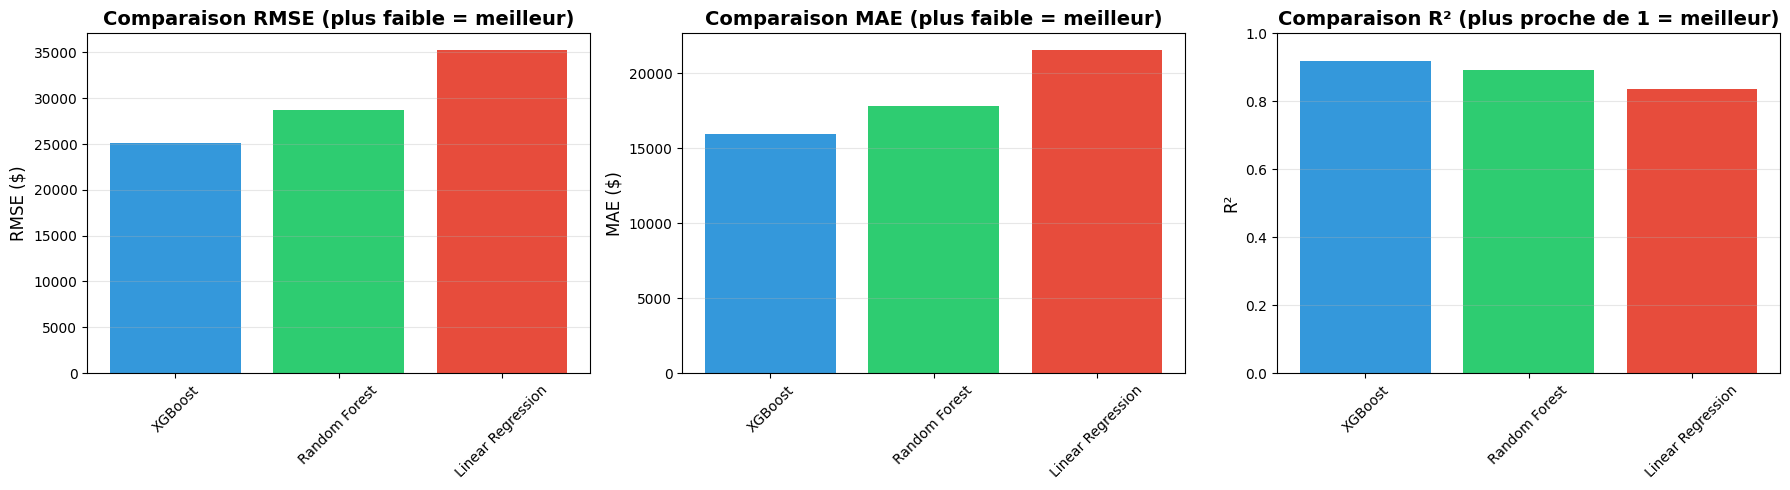

📊 Graphiques de comparaison affichés!


In [10]:
# Visualisation graphique de la comparaison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graphique 1: RMSE
axes[0].bar(results['Modèle'], results['Test RMSE'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_title('Comparaison RMSE (plus faible = meilleur)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Graphique 2: MAE
axes[1].bar(results['Modèle'], results['Test MAE'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_title('Comparaison MAE (plus faible = meilleur)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE ($)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Graphique 3: R²
axes[2].bar(results['Modèle'], results['Test R²'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[2].set_title('Comparaison R² (plus proche de 1 = meilleur)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R²', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Graphiques de comparaison affichés!")

## 9️⃣ Visualiser dans MLflow UI

Pour visualiser tous vos runs dans l'interface MLflow:

1. Ouvrez un terminal PowerShell
2. Naviguez vers le dossier du projet
3. Lancez MLflow UI:
   ```
   mlflow ui
   ```
4. Ouvrez votre navigateur à: **http://localhost:5000**

Dans MLflow UI, vous pourrez:
- ✅ Voir tous vos runs dans l'expérience "House-Prices-Notebook-3-Models"
- ✅ Comparer les métriques entre les modèles
- ✅ Télécharger les modèles entraînés
- ✅ Visualiser les graphiques de performance

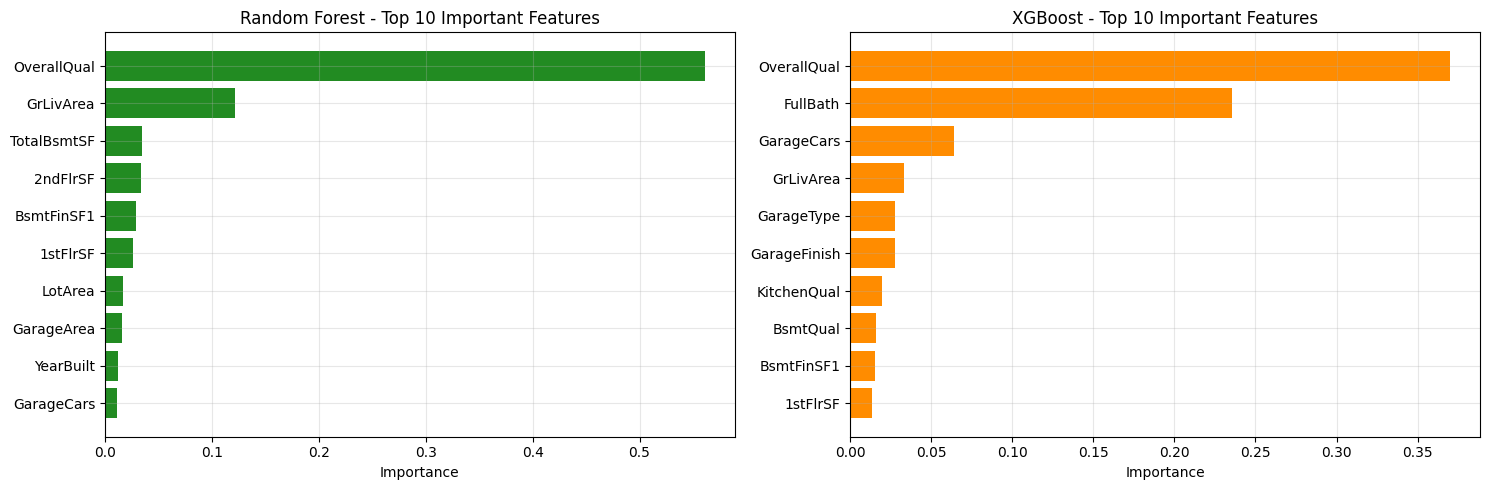

✅ Feature importance analysis complete


In [11]:
# ============================================================================
# ADVANCED VISUALIZATIONS
# ============================================================================
# Cell 11: Feature Importance Analysis

# Feature importance for Random Forest and XGBoost
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Random Forest Feature Importance
rf_importance = model_rf.feature_importances_
rf_indices = np.argsort(rf_importance)[-10:]
axes[0].barh(range(10), rf_importance[rf_indices], color='forestgreen')
axes[0].set_yticks(range(10))
axes[0].set_yticklabels([X_train.columns[i] for i in rf_indices])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 10 Important Features')
axes[0].grid(alpha=0.3)

# XGBoost Feature Importance
xgb_importance = model_xgb.feature_importances_
xgb_indices = np.argsort(xgb_importance)[-10:]
axes[1].barh(range(10), xgb_importance[xgb_indices], color='darkorange')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([X_train.columns[i] for i in xgb_indices])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 10 Important Features')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Feature importance analysis complete")

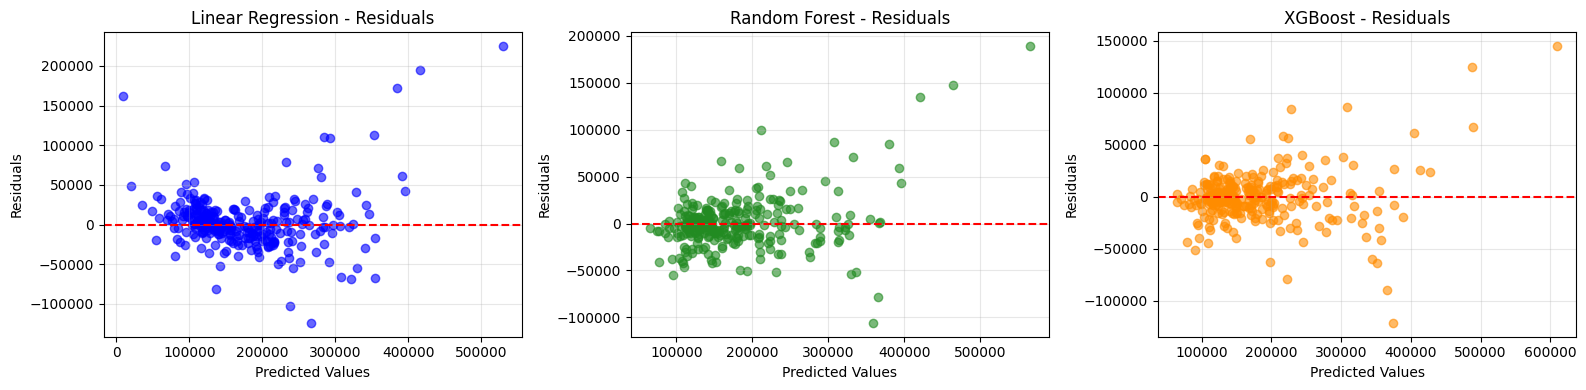

✅ Residual analysis complete


In [12]:
# Cell 12: Residual Analysis

# Residuals for all models
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

residuals_lr = y_test.values - y_pred_test_lr
residuals_rf = y_test.values - y_pred_test_rf
residuals_xgb = y_test.values - y_pred_test_xgb

# Linear Regression
axes[0].scatter(y_pred_test_lr, residuals_lr, alpha=0.6, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression - Residuals')
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_pred_test_rf, residuals_rf, alpha=0.6, color='forestgreen')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest - Residuals')
axes[1].grid(alpha=0.3)

# XGBoost
axes[2].scatter(y_pred_test_xgb, residuals_xgb, alpha=0.6, color='darkorange')
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].set_title('XGBoost - Residuals')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Residual analysis complete")

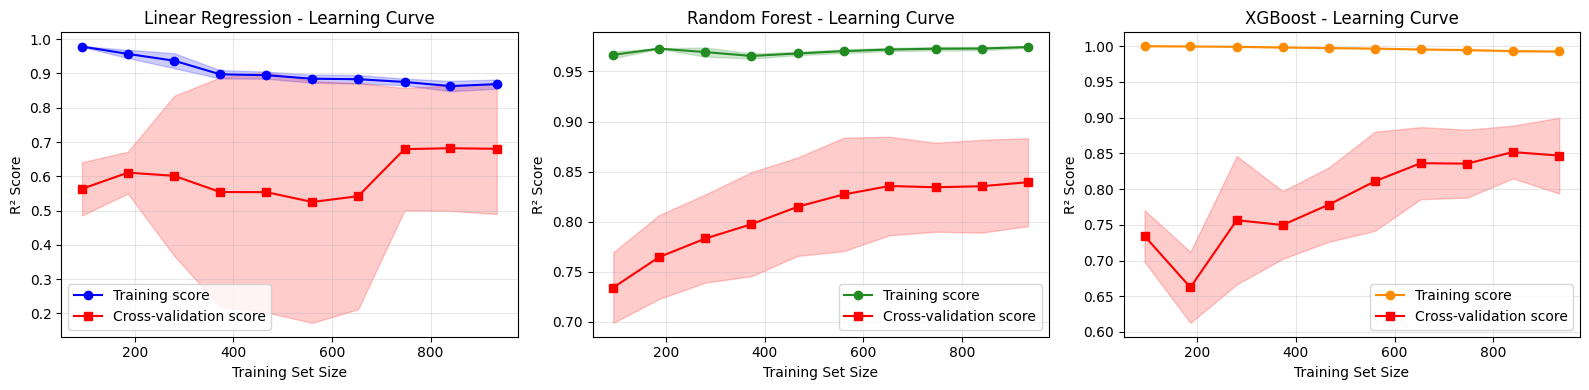

✅ Learning curves generated


In [13]:
# Cell 13: Learning Curves (Training vs Test Error)

from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

models = {'Linear Regression': model_lr, 'Random Forest': model_rf, 'XGBoost': model_xgb}
colors = ['blue', 'forestgreen', 'darkorange']

for idx, (model_name, model) in enumerate(models.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='r2', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[idx].plot(train_sizes, train_mean, 'o-', color=colors[idx], label='Training score')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color=colors[idx])
    axes[idx].plot(train_sizes, val_mean, 's-', color='red', label='Cross-validation score')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[idx].set_xlabel('Training Set Size')
    axes[idx].set_ylabel('R² Score')
    axes[idx].set_title(f'{model_name} - Learning Curve')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Learning curves generated")

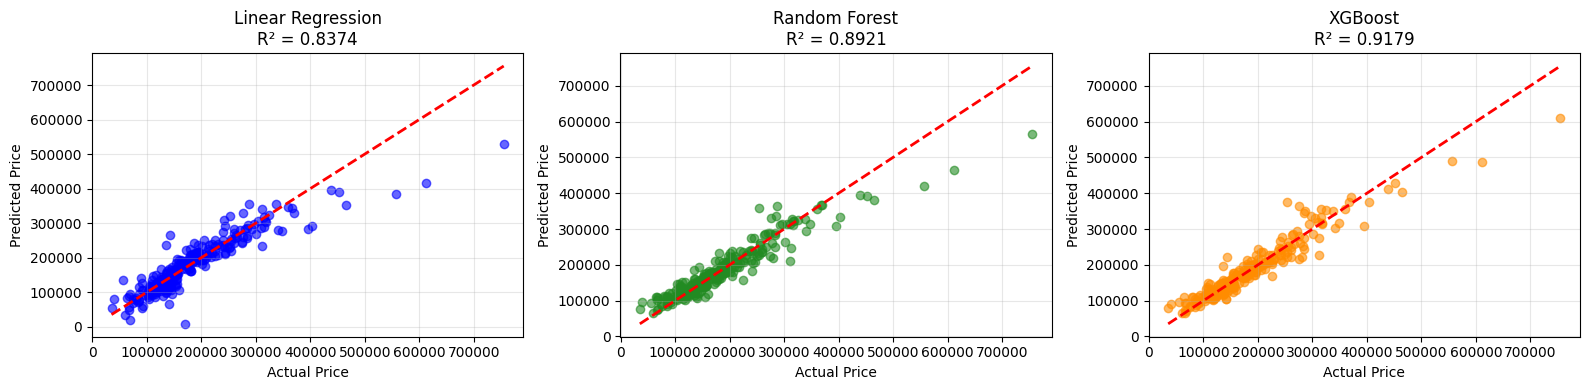

✅ Actual vs Predicted visualization complete


In [14]:
# Cell 14: Actual vs Predicted (Scatter plots)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Linear Regression
axes[0].scatter(y_test, y_pred_test_lr, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Linear Regression\nR² = {r2_test_lr:.4f}')
axes[0].grid(alpha=0.3)

# Random Forest
axes[1].scatter(y_test, y_pred_test_rf, alpha=0.6, color='forestgreen')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title(f'Random Forest\nR² = {r2_test_rf:.4f}')
axes[1].grid(alpha=0.3)

# XGBoost
axes[2].scatter(y_test, y_pred_test_xgb, alpha=0.6, color='darkorange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')
axes[2].set_title(f'XGBoost\nR² = {r2_test_xgb:.4f}')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Actual vs Predicted visualization complete")


📊 Cross-Validation Results (5-Fold):
                   R² Mean  R² Std    MSE Mean    MAE Mean
Linear Regression   0.6804  0.1897  42983.0172  21436.5844
Random Forest       0.8396  0.0440  30940.4309  18403.8298
XGBoost             0.8479  0.0539  29956.8714  17095.6295


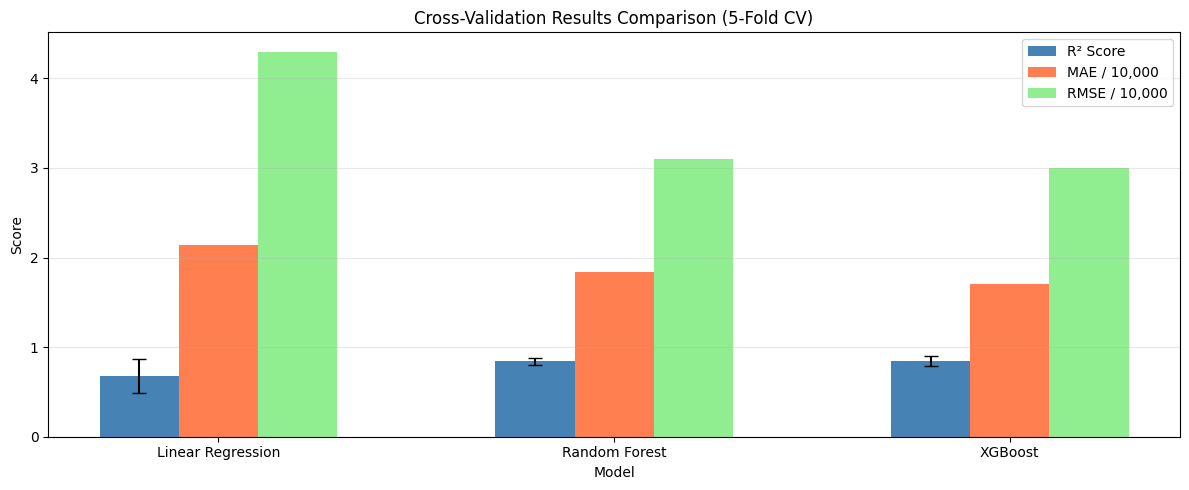


✅ Cross-validation analysis complete


In [15]:
# Cell 15: Cross-Validation Scores Analysis

from sklearn.model_selection import cross_validate

# Compute cross-validation scores with multiple metrics
cv_metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
models_dict = {
    'Linear Regression': model_lr,
    'Random Forest': model_rf,
    'XGBoost': model_xgb
}

cv_results = {}

for model_name, model in models_dict.items():
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=cv_metrics, n_jobs=-1)
    cv_results[model_name] = {
        'R² Mean': np.mean(scores['test_r2']),
        'R² Std': np.std(scores['test_r2']),
        'MSE Mean': np.sqrt(-np.mean(scores['test_neg_mean_squared_error'])),
        'MAE Mean': -np.mean(scores['test_neg_mean_absolute_error'])
    }

cv_df = pd.DataFrame(cv_results).T
print("\n📊 Cross-Validation Results (5-Fold):")
print("="*70)
print(cv_df.round(4))

# Visualization
fig, ax = plt.subplots(figsize=(12, 5))

x_pos = np.arange(len(models_dict))
width = 0.2

r2_means = [cv_results[model]['R² Mean'] for model in models_dict]
r2_stds = [cv_results[model]['R² Std'] for model in models_dict]

ax.bar(x_pos - width, r2_means, width, label='R² Score', yerr=r2_stds, capsize=5, color='steelblue')

mae_means = [cv_results[model]['MAE Mean']/10000 for model in models_dict]  # Scale for visibility
ax.bar(x_pos, mae_means, width, label='MAE / 10,000', color='coral')

mse_means = [cv_results[model]['MSE Mean']/10000 for model in models_dict]  # Scale for visibility
ax.bar(x_pos + width, mse_means, width, label='RMSE / 10,000', color='lightgreen')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Results Comparison (5-Fold CV)')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_dict.keys())
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Cross-validation analysis complete")